## Part 1 Build Dataset

In [1]:
import tools
import pickle
import numpy as np

def make_sorted_list_and_save(days):
    pickle_in = open("stock_price_dict.pickle","rb")
    price_dict_ = pickle.load(pickle_in)
    #DATA_DIR = 'D:\Dataset\EarningsCallData\ReleasedDataset\ReleasedDataset_mp3'
    DATA_DIR = '.\EarningsCallData\ACL19_Release\ACL19_Release'
    stock_movement_3days, text_all, date, company = tools.calculate_movement(price_dict_, days, DATA_DIR)
    print(len(stock_movement_3days), len(text_all), len(date))

    combined_list = list(zip(date, stock_movement_3days, company, text_all)) #进行数据的聚合、组合或并行处理。
    print(len(combined_list))
    sorted_list = sorted(combined_list, key=lambda x: x[0])#按照列表中元素的第一个索引（日期）进行排序

    np.save(f'sorted_list_{days}days.npy', sorted_list)

def make_and_save(days):
    make_sorted_list_and_save(days)

if __name__ == "__main__":
    print()
    make_and_save(3)

  5%|▍         | 27/572 [00:00<00:06, 87.66it/s]

Error Company: Aetna IncDate: 2017-01-31
Error Company: Aetna IncDate: 2017-05-02
Error Company: Aetna IncDate: 2017-10-31


 19%|█▊        | 107/572 [00:01<00:05, 89.22it/s]

Error Company: CA, Inc.Date: 2017-08-02


 99%|█████████▉| 565/572 [00:06<00:00, 96.03it/s]

Error Company: Vulcan MaterialsDate: 2017-08-02


100%|██████████| 572/572 [00:06<00:00, 92.66it/s]


24.237429941531154
563 563 563
563


## Part 2 Token-Level Encoder

In [2]:
import transformers
from tqdm import tqdm #用于在循环迭代中显示进度条的库
import torch
import re

#Generate sentence representation 使用预训练的语言模型来计算文本的嵌入表示
def emb_str(text):
    input_ids = torch.tensor([tokenizer.encode(text)])[:,:512] #使用 tokenizer 对文本进行编码，将其转换为输入张量 input_ids。编码后的张量可能会被裁剪为最大长度512。
    # print(input_ids.shape)
    with torch.no_grad(): #是一个上下文管理器，用于在执行期间禁用梯度计算。在这个上下文中，所有的张量操作都不会被跟踪，也不会导致梯度被计算和存储。这在进行推断或评估时非常有用，因为在这些情况下通常不需要计算梯度。
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples 使用模型对输入张量进行前向传递，获得最后一层隐藏状态 只取第一个元素
        emb = last_hidden_states.cpu().numpy() #将最后一层隐藏状态转移到 CPU 上，并将其转换为 NumPy 数组
    return emb
import re
        
# Padding
def make(days,name):
    list = np.load(f"{name}_list_{days}days.npy")
    embs = []
    labels = []
    sentence_len = []
    features = []
    categories = []
    for i in tqdm(range(len(list))):
        # print(list[i])
        text = (list[i][2] + "\n" + list[i][3]).split("\n")#company \n text contnent
        sentence_len.append(len(text))
        text_embs = emb_str(text)
        text_embs = np.squeeze(text_embs)#将 text_embs 中的单维度条目进行删除，以便在后续的处理中更方便地使用
        # text_embs = np.concatenate((text_embs, np.array([np.array(past_volatility_all[i])] * len(text_embs))), axis=1)
        embs.append(text_embs)
        labels.append(float(list[i][1]))#movement value->labels

        # 提取理解数据大小作为数字特征
        numbers = [float(num) for num in re.findall(r'-?\d+(?:\.\d+)?', "\n".join(text))]
        if len(numbers) > 0:
            feature = np.mean(numbers)  # 使用平均值作为数字特征
            features.append(feature)  # 将数字特征添加到对应的样本中
    b = np.zeros([len(embs),len(max(embs,key = lambda x: len(x))),1024])#创建一个全零数组 b，形状为 (len(embs), max_sentence_len, 1024)，用于存储嵌入向量，并将嵌入向量复制到 b 中对应的位置
    for i,j in enumerate(embs):#使用 enumerate(embs) 遍历嵌入向量列表 embs，其中 i 是索引，j 是对应的嵌入向量
        b[i][0:len(j),:] = j #将嵌入向量 j 复制到数组 b 的对应位置。这里使用了切片操作 0:len(j) 来确保复制的部分与嵌入向量的长度一致
    print(b.shape)
    print(len(labels))

    np.save(f"{name}_embed_{days}days.npy", b)
    np.save(f"{name}_label_{days}days.npy", labels)
    np.save(f"{name}_features_{days}days.npy", features)


def make_emb(days):
    make(days, "sorted")

if __name__ == "__main__":
    print()
    model = transformers.BertModel.from_pretrained('./bert-large-uncased-whole-word-masking')#通过加载预训练的BERT模型来创建一个BERT模型实例
    tokenizer = transformers.BertTokenizer.from_pretrained('./bert-large-uncased-whole-word-masking')
    make_emb(3)

100%|██████████| 563/563 [09:31<00:00,  1.01s/it]


(563, 512, 1024)
563


## Part 3 Customized Sentence-level Transformer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

#### Example for single task

In [4]:
#给定的批量矩阵中进行遮蔽操作
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false

    In place operation

    :param tns:
    :return:
    """
    #在遮蔽过程中，矩阵中满足条件 i <= j（如果mask_diagonal为True）或 i < j（如果mask_diagonal为False）的元素将被遮蔽（置为指定的maskval值）。
    b, h, w = matrices.size()#函数的输入参数matrices是一个大小为 (batch_size, height, width) 的张量，表示一批矩阵。maskval参数是要用于遮蔽的值，默认为0.0。mask_diagonal参数控制是否遮蔽对角线上的元素，默认为True，即遮蔽对角线上的元素

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)#生成一个大小为 (2, num_indices) 的张量，其中 num_indices 是根据矩阵大小和遮蔽对角线的设置计算得到的索引数量。这个张量包含了上三角部分（包括或不包括对角线）的索引
    matrices[:, indices[0], indices[1]] = maskval #将遮蔽值 maskval 赋值给 matrices 张量中对应索引的位置。通过这样的操作，上三角部分的元素将被遮蔽（置为指定的遮蔽值），而下三角部分的元素将保持不变



def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)#检查张量中是否包含NaN



# Self-Attention 自注意力机制是用于捕捉序列数据中不同位置之间的关联关系
class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()#表示调用 nn.Module 类的构造函数，用于初始化继承自 nn.Module 的子类的基本功能

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)#将输入 x 映射到键（keys）、查询（queries）和值（values）空间的线性变换

        self.unifyheads = nn.Linear(heads * emb, emb)#heads * emb 表示输入特征的大小，emb 表示输出特征的大小。

    def forward(self, x):#输入 x 的形状为 (b, t, e)，其中 b 是批量大小，t 是序列长度，e 是嵌入维度。首先，通过线性变换将输入分别映射到键、查询和值的空间，并将维度进行调整，使其适应自注意力计算的需求

        b, t, e = x.size()
        h = self.heads#在 SelfAttention 类的前向传播函数中，h = self.heads 是将类的 self.heads 属性赋值给局部变量 h。self.heads 表示模型中的注意力头数，而 h 则是用于表示头数的变量
        assert e == self.emb# 断言语句，用于检查变量 e 是否等于模型的 self.emb 属性. 如果断言条件为 False，则会触发断言错误，并抛出异常。

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)#self.tovalues(x) 表示将输入张量 x 经过线性变换 self.tovalues，得到值表示，形状为 (b, t, h * e). b 表示批量大小，t 表示序列长度，h 表示注意力头数，e 表示特征维度。通过变换操作，将输入张量的特征维度转换为 (h * e)，并在维度上扩展为 (b, t, h, e) 的形状，以便后续的自注意力计算

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)
        #首先，使用 transpose 将维度 1 和维度 2 进行转置，以便在后续计算中，序列长度 t 可以成为注意力矩阵的行数，而特征维度 e 可以成为注意力矩阵的列数。然后，使用 contiguous 确保张量在内存中是连续存储的
        #使用 view 将形状为 (b, h, t, e) 的张量重塑为形状为 (b * h, t, e) 的张量。这样做是为了将注意力头数 h 与批量大小 b 进行合并，形成一个新的批量维度
        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))#对 queries 和 keys 进行缩放，除以 (e ** (1/4))，这是为了缩放注意力矩阵的值，使得在计算注意力概率时更稳定。
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))#使用批量矩阵乘法 torch.bmm 计算查询向量和键向量之间的点积.点积操作会将查询向量的每个查询与键向量的每个键进行相乘，并将结果按键的维度进行求和。这将产生一个注意力矩阵，其形状为 (b * h, t, t)，其中每个元素表示查询与键之间的相似度或相关性

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False) #如果 self.mask 为真，将屏蔽掉 dot 矩阵的下三角部分，包括对角线。mask_() 函数被用于执行屏蔽操作。

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities 通过在维度2上对 dot 进行 softmax 操作，得到行级别的自注意力概率

        assert not contains_nan(dot[:, 1:, :]) # only the forst row may contain nan

        if self.mask == 'first':# 如果 self.mask 为 'first'，则将 dot 的第一行克隆为新的张量，并将其置为零。这是为了处理在 softmax 操作中可能导致除以零的情况，从而避免产生 NaN 值
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e) #自注意力概率矩阵 dot 与值矩阵 values 执行矩阵乘法，得到经过自注意力机制处理后的输出

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e) #通过交换 h 和 t 的顺序，并将头数 h 与特征维度 e 相乘，将输出 out 的形状转换为 (b, t, h * e)

        return self.unifyheads(out)


In [5]:
# Transformer Block

class TransformerBlock(nn.Module):#Transformer Block 是 Transformer 模型的基本构建块之一，它由自注意力层、前馈神经网络层和残差连接组成。
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.5):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads, mask=mask)#自注意力层，用于对输入进行自注意力计算
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)#两个 Layer Normalization 层，用于对自注意力层输出和前馈神经网络层输出进行归一化
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),#线性变换层，它将输入的特征维度 emb 转换为 ff_hidden_mult * emb 的维度。
            nn.ReLU(), #这是一个 ReLU 激活函数，它对线性变换的输出进行非线性变换，引入非线性性质
            nn.Linear(ff_hidden_mult * emb, emb) #另一个线性变换层，它将前一层的输出维度 ff_hidden_mult * emb 转换回原始的特征维度 emb
        )#self.ff 是一个 nn.Sequential 对象，它定义了一个前馈神经网络层。这个前馈神经网络层由两个线性变换层和一个 ReLU 激活函数组成。通过这个前馈神经网络层，模型可以对输入的特征进行非线性变换和映射。这有助于模型学习更复杂的特征表示和抽象
        #因为在 Transformer 模型中的每个编码层中，存在一个前馈神经网络（Feed-Forward Neural Network）层，用于引入非线性性质和增加模型的表示能力。该前馈神经网络层通常由两个线性变换（nn.Linear）和一个非线性激活函数（如 ReLU）组成。
        #在该前馈神经网络层中，将输入特征的维度从 emb 转换为 ff_hidden_mult * emb，其中 ff_hidden_mult 是一个超参数，通常设置为大于 1 的值。这样做的目的是通过引入更高维度的表示空间和非线性变换，使模型能够学习更复杂的特征和模式。
        #在前馈神经网络层后面，通过另一个线性变换将维度从 ff_hidden_mult * emb 转换回原始的特征维度 emb。这样做是为了保持编码层的输出与输入的维度一致，以便能够进行残差连接（residual connection），从而更好地传递和保留原始输入的信息。
        #通过引入非线性性质和通过线性变换改变特征维度的方式，前馈神经网络层在编码层中增加了模型的非线性表示能力，同时保持了输入和输出的一致性，有助于模型进行更高级的特征提取和表示学习。
        
        self.do = nn.Dropout(dropout)# Dropout 层，用于在训练过程中进行随机失活以防止过拟合。

    def forward(self, x):#定义了 TransformerBlock 的前向传播过程。

        attended = self.attention(x) #将输入 x 传递给自注意力层（self.attention），以计算自注意力概率矩阵

        x = self.norm1(attended + x) #将自注意力层的输出（attended）与输入 x 相加，并应用层归一化（self.norm1）来得到规范化后的输出

        x = self.do(x) #应用丢弃（dropout）操作（self.do）来对输出进行正则化，防止过拟合

        fedforward = self.ff(x)#将前一步骤的输出 x 传递给前馈神经网络层（self.ff），进行非线性变换

        x = self.norm2(fedforward + x)#将前馈神经网络层的输出（fedforward）与之前的输出 x 相加，并再次应用层归一化

        x = self.do(x)

        return x
    #通过以上步骤，TransformerBlock 实现了一个 Transformer 模型中的一个编码层，其中包括了自注意力机制、前馈神经网络和残差连接。这些操作有助于模型进行特征提取和表示学习，从而实现对输入序列的编码


In [6]:
##RTransformer 序列回归

class RTransformer(nn.Module):
    """
    Transformer for sequences Regression    
    
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        #self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens) 词嵌入层（Token Embedding）：该层将输入的词索引映射到连续的向量表示，即词嵌入。这种嵌入通常使用一个 nn.Embedding 层实现，其中 embedding_dim 参数指定了词嵌入的维度，而 num_embeddings 参数表示词汇表中的单词数量。
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)#位置嵌入层（Position Embedding）：由于 Transformer 模型没有显式的位置信息，为了引入序列中每个位置的相对位置信息，使用了位置嵌入。该层将输入序列的位置索引映射为相应的位置嵌入向量。在这个模型中，使用了一个 nn.Embedding 层来实现位置嵌入，其中 embedding_dim 参数指定了位置嵌入的维度，而 num_embeddings 参数表示序列的最大长度。

        tblocks = []#在这段代码中，通过一个循环，将多个 TransformerBlock 实例化并添加到 tblocks 列表中。这个循环的次数由参数 depth 控制，表示模型中 TransformerBlock 的层数
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)#通过 nn.Sequential 将 tblocks 列表中的多个 TransformerBlock 组合成一个串行的模型结构，即 self.tblocks。这样做可以方便地将输入按顺序通过所有的 TransformerBlock 进行处理。

        self.toprobs = nn.Linear(emb, num_classes)#通过 nn.Linear 层（self.toprobs）将最后一个 TransformerBlock 的输出映射到预测的目标类别数量（num_classes）。这个线性层将输出的特征维度（emb）转换为目标类别的数量，以便进行后续的分类操作。

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        #参数 x 是一个批次（batch）大小乘以序列长度的整数张量，表示输入的令牌索引。模型的目标是基于先前的令牌预测每个令牌的对数概率向量
        sentences_emb = x#将输入 x 赋值给 sentences_emb 变量，表示输入的句子嵌入
        b, t, e = x.size()

        positions = self.pos_embedding(torch.arange(t))[None, :, :].expand(b, t, e)#对序列长度的范围进行嵌入，获取位置编码。位置编码的目的是为了在输入序列中引入每个令牌的位置信息。
        #positions = torch.tensor(positions, dtype=torch.float32)
        x = sentences_emb + positions#将位置编码添加到输入的句子嵌入中，以获得具有位置信息的句子表示
        x = self.do(x)

        x = self.tblocks(x)#每个 TransformerBlock 都会对输入序列进行自注意力计算和前馈神经网络操作，以获取更好的表示

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension 对序列的时间维度进行池化操作，得到一个固定长度的向量表示。max_pool 池化操作选择最大值，mean_pool 池化操作选择平均值。
        x = self.toprobs(x)#通过 self.toprobs 对输入 x 进行线性变换，将其映射到预测类别的空间。
        x = torch.squeeze(x)#将张量 x 去除维度为1的尺寸，使其变为一维张量。这通常是为了消除不必要的尺寸，以便与预期的输出形状相匹配。在这里，x 是预测的对数概率向量，去除维度为1的尺寸后，得到的张量表示每个预测类别的对数概率。

        return x

In [7]:
# Format Dataset
import torch.nn.utils.rnn as rnn_utils
from torch.utils import data

def pad_texts(texts, padding_value=0):
    max_length = max(len(text) for text in texts)
    padded_texts = [torch.cat([torch.tensor(text), torch.full((max_length - len(text), *text.shape[1:]), padding_value)], dim=0) for text in texts]
    return torch.stack(padded_texts)

class Dataset(data.Dataset):
    def __init__(self, texts, labels, features, audio):
        'Initialization'
        self.labels = labels
        self.features = features
        self.texts = pad_texts(texts)
        self.audio = audio

        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        if torch.is_tensor(index):
            index = index.tolist()#您检查index是否是一个张量对象，如果是，您将其转换为Python列表。这是为了兼容处理张量索引和标量索引的情况。

        # Load data and get label
        X = self.texts[index]
        y = self.labels[index]
        z = self.features[index]
        a = self.audio[index]

        # Pad X to make all sequences have the same length
        X_padded = rnn_utils.pad_sequence([torch.tensor(x) for x in X], batch_first=True)

        y = torch.tensor(y, dtype=torch.float32)
        z = torch.tensor(z, dtype=torch.float32)
        a = torch.tensor(a, dtype=torch.float32)
        y = torch.unsqueeze(y, 0)  # Convert y to shape (1, num_samples)
        z = torch.unsqueeze(z, 0)  # Convert z to shape (1, num_samples)
        a = torch.unsqueeze(a, 0)  # Convert z to shape (1, num_samples)
        return X_padded, y, z, a


In [8]:
import numpy as np
# Load your own the whole dataset
TEXT_emb = np.load("sorted_embed_3days.npy", allow_pickle=True)
LABEL_emb = np.load("sorted_label_3days.npy", allow_pickle=True)
NUM_emb = np.load("sorted_features_3days.npy", allow_pickle=True)
Audio_emb = np.load("sorted_audio_3days.npy", allow_pickle=True)

## Part 3 Build the Predictor

In [9]:
# Main function

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import random, sys, math, gzip

from tqdm import tqdm
from tqdm import tqdm_notebook
from torch.nn.utils.rnn import pad_sequence
import time
import matplotlib.pyplot as plt

NUM_CLS = 1

def collate_fn(batch):
    # Split the batch into separate lists of inputs, labels, and features
    inputs, labels, features, audio = zip(*batch)

    # Pad the sequences using pad_sequence
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    features = [pad_sequence([torch.tensor(seq)], batch_first=True, padding_value=0) for seq in features]
    audio = [pad_sequence([torch.tensor(seq)], batch_first=True, padding_value=0) for seq in audio]
    return inputs, labels, features, audio

def pad_sequence_with_padding_value(sequences, padding_value=0, batch_first=True):
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = [torch.cat([seq, torch.full((max_len - len(seq), *seq.shape[1:]), padding_value)], dim=0) for seq in sequences]
    return torch.stack(padded_sequences, dim=0) if batch_first else torch.stack(padded_sequences, dim=1)


def go(arg):
    """
    Creates and trains a basic transformer for any regression task.
    """

    if arg.final:#arg.final 为真,按照 8:2 的比例划分为训练集和验证集。

        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)
        train_audio, val_audio = train_test_split(Audio_emb, test_size=0.2)
        training_set = Dataset(train, train_label, train_num, train_audio)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label, val_num, val_audio)

    else:
        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)
        train_audio, val_audio = train_test_split(Audio_emb, test_size=0.2)
        train, val = train_test_split(train, test_size=0.2)#当 arg.final 为假时，即非最终情况，首先进行一次训练集和验证集的划分，然后再次对训练集和验证集进行划分的目的是为了创建更小的训练集和验证集.这种两次划分的方式可以帮助在较小的数据集上进行快速实验和调试，从而更高效地调整模型的超参数、模型结构等，以达到更好的性能和泛化能力
        train_label, val_label = train_test_split(train_label, test_size=0.2)
        train_num, val_num = train_test_split(train_num, test_size=0.2)
        train_audio, val_audio = train_test_split(train_audio, test_size=0.2)

        training_set = Dataset(train, train_label, train_num, train_audio)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label, val_num, val_audio)

    trainloader = torch.utils.data.DataLoader(training_set, batch_size=arg.batch_size, shuffle=False, num_workers=0)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=arg.batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
    print('training examples', len(training_set))
    #print(f'- nr. of {"test" if arg.final else "validation"} examples {len(test_iter)}')

    if arg.final:
          print('test examples', len(val_set))
    else:
          print('validation examples', len(val_set))
    #如果arg.final为True，则表示当前是最终的测试阶段，使用的是测试集。因此，打印语句print('test examples', len(val_set))输出测试集的样本数量。
    #如果arg.final为False，则表示当前是验证阶段，使用的是验证集。因此，打印语句print('validation examples', len(val_set))输出验证集的样本数量。

    # create the model
    model = RTransformer(emb=arg.embedding_size, heads=arg.num_heads, depth=arg.depth, \
                         seq_length=arg.max_length, num_tokens=arg.vocab_size, num_classes=NUM_CLS, max_pool=arg.max_pool)
    #     if torch.cuda.is_available():
    #         model.cuda()

    opt = torch.optim.Adam(lr=arg.lr, params=model.parameters())#使用Adam优化器进行参数优化，其中学习率由arg.lr指定

    # training loop
    start_time = time.time()
    seen = 0#记录已经处理的样本数
    evaluation= {'epoch': [] ,'Train Accuracy': [], 'Test Accuracy' :[]}#epoch用于记录训练的轮数，Train Accuracy用于记录每轮训练后模型在训练集上的准确率，Test Accuracy用于记录每轮训练后模型在测试集上的准确率。
    for e in tqdm_notebook(range(arg.num_epochs)):
        train_loss_tol = 0.0
        print('\n epoch ' ,e)
        model.train(True)#启用训练模式

        for i, data in tqdm_notebook(enumerate(trainloader)):
            if i > 2:
                break
            # learning rate warmup学习率预热
            # - we linearly increase the learning rate from 10e-10 to arg.lr over the first
            #   few thousand batches
            if arg.lr_warmup > 0 and seen < arg.lr_warmup:
                lr = max((arg.lr / arg.lr_warmup) * seen, 1e-10)
                opt.lr = lr

            opt.zero_grad()#清零优化器的梯度

            inputs, labels, features, audio = data
            inputs = Variable(inputs.type(torch.FloatTensor))#将输入数据转换为FloatTensor类型，并将其封装在Variable中（用于自动求导）
            # labels = torch.tensor(labels, dtype=torch.float32)
            labels = labels.clone().detach()#克隆并分离标签，并将其转换为浮点型
            features = torch.tensor(features, dtype=torch.float32)
            features = features.clone().detach()
            audio = torch.tensor(audio, dtype=torch.float32)
            audio = audio.clone().detach()
            if inputs.size(1) > arg.max_length:
               inputs = inputs[:, :arg.max_length, :]#如果输入数据的长度超过了arg.max_length，则进行截断处理
            out = model(inputs)
            out = torch.unsqueeze(out, 0)
            # print(out)
            out = out.float()
            labels = labels.float()
            features = features.float()

            # print(out.shape,labels.shape)

            loss = F.mse_loss(out, labels)#计算损失函数（均方误差损失）
            train_loss_tol += loss#累加训练损失

            loss.backward()#反向传播计算梯度

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if arg.gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), arg.gradient_clipping)#调用nn.utils.clip_grad_norm_函数，传入模型的参数和梯度裁剪阈值作为参数，对模型的梯度进行裁剪。裁剪操作的目的是限制梯度的范数，以防止梯度爆炸的问题

            opt.step()#更新模型的参数

            seen += inputs.size(0)#更新迭代次数seen,增加当前批次的样本数量
            # tbw.add_scalar('classification/train-loss', float(loss.item()), seen)
        # print('train_loss: ',train_loss_tol)
        train_loss_tol = train_loss_tol /( i +1)#计算训练损失的平均值
        training_time = time.time()-start_time
        print("Training time: {}".format(training_time))
        with torch.no_grad():#上下文管理器，表示接下来的计算不会对梯度产生影响

            model.train(False)#进入评估模式
            tot, cor= 0.0, 0.0

            loss_test = 0.0#初始化测试集的损失loss_test为0.0
            for i, data in tqdm_notebook(enumerate(testloader)):
                if i > 2:
                    break
                inputs, labels, features, audio = data
                inputs = torch.tensor(inputs, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.float32)
                features = [torch.tensor(seq, dtype=torch.float32) for seq in features]  # Convert each feature sequence to a tensor
                audio = [torch.tensor(seq, dtype=torch.float32) for seq in audio]
                if inputs.size(1) > arg.max_length:
                    inputs = inputs[:, :arg.max_length, :]
                out = model(inputs)

                loss_test += F.mse_loss(out, labels)#计算预测结果与真实标签之间的均方误差损失，并累加到loss_test中
                # tot = float(inputs.size(0))
                # cor += float(labels.sum().item())

            acc = loss_test.numpy()
            training_time = time.time()-start_time
            print("Training time: {}".format(training_time))
            if arg.final:
                print('test accuracy', acc)
            else:
                print('validation accuracy', acc)#准确率计算实际上是损失值而不是准确率

        #torch.save(model, './checkpoint/epoch' +str(e) +'.pth')
        torch.save(model, '\\Users\\zc22364\\Downloads\\HTML_partial_reproduction-main\\HTML_partial_reproduction-main\\checkpoint\\epoch' +str(e) +'.pth')
        # print(train_loss_tol)
        # print(acc)
        train_loss_tol = train_loss_tol.detach().numpy()
        evaluation['epoch'].append(e)
        evaluation['Train Accuracy'].append(train_loss_tol)#实际上存储的是训练集的损失值
        evaluation['Test Accuracy'].append(acc)#测试集/验证集的准确率


    evaluation = pd.DataFrame(evaluation)
    evaluation.sort_values(["Test Accuracy"] ,ascending=True ,inplace=True)

    return evaluation
    # tbw.add_scalar('classification/test-loss', float(loss.item()), e)

  


training examples 360
validation examples 90


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]


 epoch  0


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:98: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:129: UserWarning: Using a target size (tor

Training time: 2.7058634757995605


c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:153: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:158: UserWarning: To copy construct from a 

Training time: 3.5632517337799072
validation accuracy 211.29262

 epoch  1


0it [00:00, ?it/s]

Training time: 5.96565055847168


0it [00:00, ?it/s]

Training time: 6.701777219772339
validation accuracy 33.383934

 epoch  2


0it [00:00, ?it/s]

Training time: 8.971210718154907


0it [00:00, ?it/s]

Training time: 9.694108486175537
validation accuracy 1.1733108

 epoch  3


0it [00:00, ?it/s]

Training time: 12.045182704925537


0it [00:00, ?it/s]

Training time: 12.70182466506958
validation accuracy 4.142598

 epoch  4


0it [00:00, ?it/s]

Training time: 15.155973196029663


0it [00:00, ?it/s]

Training time: 15.877007484436035
validation accuracy 1.1744843

 epoch  5


0it [00:00, ?it/s]

Training time: 18.23086404800415


0it [00:00, ?it/s]

Training time: 18.994091510772705
validation accuracy 1.6014211

 epoch  6


0it [00:00, ?it/s]

Training time: 21.145215034484863


0it [00:00, ?it/s]

Training time: 21.84230065345764
validation accuracy 1.3041447

 epoch  7


0it [00:00, ?it/s]

Training time: 24.156064748764038


0it [00:00, ?it/s]

Training time: 24.897281169891357
validation accuracy 2.1301873

 epoch  8


0it [00:00, ?it/s]

Training time: 27.32956027984619


0it [00:00, ?it/s]

Training time: 28.026564359664917
validation accuracy 1.6690116

 epoch  9


0it [00:00, ?it/s]

Training time: 30.3553147315979


0it [00:00, ?it/s]

Training time: 31.118963718414307
validation accuracy 1.7718734

 epoch  10


0it [00:00, ?it/s]

Training time: 33.424335956573486


0it [00:00, ?it/s]

Training time: 34.162285804748535
validation accuracy 2.1247497

 epoch  11


0it [00:00, ?it/s]

Training time: 36.59955859184265


0it [00:00, ?it/s]

Training time: 38.284326791763306
validation accuracy 2.1824765

 epoch  12


0it [00:00, ?it/s]

Training time: 40.43145418167114


0it [00:00, ?it/s]

Training time: 41.09065556526184
validation accuracy 1.2817932

 epoch  13


0it [00:00, ?it/s]

Training time: 43.295679330825806


0it [00:00, ?it/s]

Training time: 43.96638774871826
validation accuracy 1.5054789

 epoch  14


0it [00:00, ?it/s]

Training time: 46.11567735671997


0it [00:00, ?it/s]

Training time: 46.858726978302
validation accuracy 2.4684258

 epoch  15


0it [00:00, ?it/s]

Training time: 49.11906719207764


0it [00:00, ?it/s]

Training time: 49.83350491523743
validation accuracy 1.2284914

 epoch  16


0it [00:00, ?it/s]

Training time: 52.12848162651062


0it [00:00, ?it/s]

Training time: 52.85913872718811
validation accuracy 2.273098

 epoch  17


0it [00:00, ?it/s]

Training time: 55.172712087631226


0it [00:00, ?it/s]

Training time: 55.89113473892212
validation accuracy 2.1306949

 epoch  18


0it [00:00, ?it/s]

Training time: 58.222278356552124


0it [00:00, ?it/s]

Training time: 58.95772051811218
validation accuracy 1.3755488

 epoch  19


0it [00:00, ?it/s]

Training time: 61.21497130393982


0it [00:00, ?it/s]

Training time: 61.9575514793396
validation accuracy 2.750265

 epoch  20


0it [00:00, ?it/s]

Training time: 64.32429623603821


0it [00:00, ?it/s]

Training time: 65.04028367996216
validation accuracy 1.5949696

 epoch  21


0it [00:00, ?it/s]

Training time: 67.43375015258789


0it [00:00, ?it/s]

Training time: 68.15427017211914
validation accuracy 1.7507662

 epoch  22


0it [00:00, ?it/s]

Training time: 70.43483233451843


0it [00:00, ?it/s]

Training time: 71.17054915428162
validation accuracy 2.6616635

 epoch  23


0it [00:00, ?it/s]

Training time: 73.43539381027222


0it [00:00, ?it/s]

Training time: 74.18984770774841
validation accuracy 1.3813548

 epoch  24


0it [00:00, ?it/s]

Training time: 76.47638440132141


0it [00:00, ?it/s]

Training time: 77.21306467056274
validation accuracy 2.412168

 epoch  25


0it [00:00, ?it/s]

Training time: 79.49208784103394


0it [00:00, ?it/s]

Training time: 80.19963383674622
validation accuracy 2.2410026

 epoch  26


0it [00:00, ?it/s]

Training time: 82.44409537315369


0it [00:00, ?it/s]

Training time: 83.23767852783203
validation accuracy 1.47349

 epoch  27


0it [00:00, ?it/s]

Training time: 85.83052492141724


0it [00:00, ?it/s]

Training time: 86.64286017417908
validation accuracy 2.215476

 epoch  28


0it [00:00, ?it/s]

Training time: 89.12861132621765


0it [00:00, ?it/s]

Training time: 89.94790530204773
validation accuracy 1.303335

 epoch  29


0it [00:00, ?it/s]

Training time: 92.4593710899353


0it [00:00, ?it/s]

Training time: 93.25008273124695
validation accuracy 2.1665902

 epoch  30


0it [00:00, ?it/s]

Training time: 95.73829817771912


0it [00:00, ?it/s]

Training time: 96.51342821121216
validation accuracy 1.4906693

 epoch  31


0it [00:00, ?it/s]

Training time: 99.03136491775513


0it [00:00, ?it/s]

Training time: 99.81712865829468
validation accuracy 1.843431

 epoch  32


0it [00:00, ?it/s]

Training time: 102.34980344772339


0it [00:00, ?it/s]

Training time: 103.18944692611694
validation accuracy 2.9258132

 epoch  33


0it [00:00, ?it/s]

Training time: 105.74370193481445


0it [00:00, ?it/s]

Training time: 106.6076409816742
validation accuracy 1.252105

 epoch  34


0it [00:00, ?it/s]

Training time: 109.21226215362549


0it [00:00, ?it/s]

Training time: 110.09407305717468
validation accuracy 1.0559843

 epoch  35


0it [00:00, ?it/s]

Training time: 112.78395390510559


0it [00:00, ?it/s]

Training time: 113.67272114753723
validation accuracy 2.4148607

 epoch  36


0it [00:00, ?it/s]

Training time: 116.53404545783997


0it [00:00, ?it/s]

Training time: 117.40590739250183
validation accuracy 1.7988245

 epoch  37


0it [00:00, ?it/s]

Training time: 120.11554098129272


0it [00:00, ?it/s]

Training time: 121.01576447486877
validation accuracy 1.9426363

 epoch  38


0it [00:00, ?it/s]

Training time: 123.79002594947815


0it [00:00, ?it/s]

Training time: 124.68319892883301
validation accuracy 1.9322891

 epoch  39


0it [00:00, ?it/s]

Training time: 127.47995138168335


0it [00:00, ?it/s]

Training time: 128.37209630012512
validation accuracy 1.6230807

 epoch  40


0it [00:00, ?it/s]

Training time: 131.15495419502258


0it [00:00, ?it/s]

Training time: 132.014169216156
validation accuracy 1.9909596

 epoch  41


0it [00:00, ?it/s]

Training time: 134.82444286346436


0it [00:00, ?it/s]

Training time: 135.70446825027466
validation accuracy 1.6637635

 epoch  42


0it [00:00, ?it/s]

Training time: 138.33842730522156


0it [00:00, ?it/s]

Training time: 139.23211407661438
validation accuracy 2.0246835

 epoch  43


0it [00:00, ?it/s]

Training time: 141.73920679092407


0it [00:00, ?it/s]

Training time: 142.5672070980072
validation accuracy 1.6868142

 epoch  44


0it [00:00, ?it/s]

Training time: 145.11022019386292


0it [00:00, ?it/s]

Training time: 145.91416120529175
validation accuracy 2.0416656

 epoch  45


0it [00:00, ?it/s]

Training time: 148.34848403930664


0it [00:00, ?it/s]

Training time: 149.1172478199005
validation accuracy 1.7007964

 epoch  46


0it [00:00, ?it/s]

Training time: 151.61227941513062


0it [00:00, ?it/s]

Training time: 152.4255566596985
validation accuracy 2.051107

 epoch  47


0it [00:00, ?it/s]

Training time: 154.92476630210876


0it [00:00, ?it/s]

Training time: 155.69979619979858
validation accuracy 1.7099363

 epoch  48


0it [00:00, ?it/s]

Training time: 158.18390679359436


0it [00:00, ?it/s]

Training time: 159.04485630989075
validation accuracy 2.0560565

 epoch  49


0it [00:00, ?it/s]

Training time: 161.43246722221375


0it [00:00, ?it/s]

Training time: 162.21443939208984
validation accuracy 1.7155133

 epoch  50


0it [00:00, ?it/s]

Training time: 164.80071902275085


0it [00:00, ?it/s]

Training time: 165.61010313034058
validation accuracy 2.0580313

 epoch  51


0it [00:00, ?it/s]

Training time: 168.0810775756836


0it [00:00, ?it/s]

Training time: 168.8631772994995
validation accuracy 1.7199299

 epoch  52


0it [00:00, ?it/s]

Training time: 171.29443311691284


0it [00:00, ?it/s]

Training time: 172.0554494857788
validation accuracy 2.0589116

 epoch  53


0it [00:00, ?it/s]

Training time: 174.83237385749817


0it [00:00, ?it/s]

Training time: 175.69568848609924
validation accuracy 1.7227925

 epoch  54


0it [00:00, ?it/s]

Training time: 178.32922458648682


0it [00:00, ?it/s]

Training time: 179.23134422302246
validation accuracy 2.058488

 epoch  55


0it [00:00, ?it/s]

Training time: 181.90577864646912


0it [00:00, ?it/s]

Training time: 182.80179524421692
validation accuracy 1.7261028

 epoch  56


0it [00:00, ?it/s]

Training time: 185.47651553153992


0it [00:00, ?it/s]

Training time: 186.39371252059937
validation accuracy 2.0580432

 epoch  57


0it [00:00, ?it/s]

Training time: 189.10636377334595


0it [00:00, ?it/s]

Training time: 189.99965023994446
validation accuracy 1.7274692

 epoch  58


0it [00:00, ?it/s]

Training time: 192.82521295547485


0it [00:00, ?it/s]

Training time: 193.6060779094696
validation accuracy 2.0562441

 epoch  59


0it [00:00, ?it/s]

Training time: 196.37756085395813


0it [00:00, ?it/s]

Training time: 197.16252326965332
validation accuracy 1.7300086

 epoch  60


0it [00:00, ?it/s]

Training time: 200.02660870552063


0it [00:00, ?it/s]

Training time: 200.76832056045532
validation accuracy 2.0554338

 epoch  61


0it [00:00, ?it/s]

Training time: 203.45003867149353


0it [00:00, ?it/s]

Training time: 204.18092274665833
validation accuracy 1.7327517

 epoch  62


0it [00:00, ?it/s]

Training time: 206.8500006198883


0it [00:00, ?it/s]

Training time: 207.56690883636475
validation accuracy 2.0539718

 epoch  63


0it [00:00, ?it/s]

Training time: 210.05974793434143


0it [00:00, ?it/s]

Training time: 210.7648766040802
validation accuracy 1.7334054

 epoch  64


0it [00:00, ?it/s]

Training time: 213.15891242027283


0it [00:00, ?it/s]

Training time: 213.84187150001526
validation accuracy 2.051577

 epoch  65


0it [00:00, ?it/s]

Training time: 216.3426697254181


0it [00:00, ?it/s]

Training time: 217.03010892868042
validation accuracy 1.7353213

 epoch  66


0it [00:00, ?it/s]

Training time: 219.58805060386658


0it [00:00, ?it/s]

Training time: 220.2792866230011
validation accuracy 2.0497541

 epoch  67


0it [00:00, ?it/s]

Training time: 222.9054274559021


0it [00:00, ?it/s]

Training time: 223.65017127990723
validation accuracy 1.7376378

 epoch  68


0it [00:00, ?it/s]

Training time: 226.17783784866333


0it [00:00, ?it/s]

Training time: 226.966890335083
validation accuracy 2.0480382

 epoch  69


0it [00:00, ?it/s]

Training time: 229.5963273048401


0it [00:00, ?it/s]

Training time: 230.35221791267395
validation accuracy 1.7385176

 epoch  70


0it [00:00, ?it/s]

Training time: 232.9944007396698


0it [00:00, ?it/s]

Training time: 233.76107788085938
validation accuracy 2.0452359

 epoch  71


0it [00:00, ?it/s]

Training time: 236.480815410614


0it [00:00, ?it/s]

Training time: 237.24881958961487
validation accuracy 1.7670847

 epoch  72


0it [00:00, ?it/s]

Training time: 240.07891273498535


0it [00:00, ?it/s]

Training time: 240.84969544410706
validation accuracy 2.095052

 epoch  73


0it [00:00, ?it/s]

Training time: 243.7265727519989


0it [00:00, ?it/s]

Training time: 244.52702164649963
validation accuracy 1.7519732

 epoch  74


0it [00:00, ?it/s]

Training time: 247.4728078842163


0it [00:00, ?it/s]

Training time: 248.26615715026855
validation accuracy 2.0003796

 epoch  75


0it [00:00, ?it/s]

Training time: 251.13287734985352


0it [00:00, ?it/s]

Training time: 251.9171643257141
validation accuracy 1.9042969

 epoch  76


0it [00:00, ?it/s]

Training time: 254.68691110610962


0it [00:00, ?it/s]

Training time: 255.4775996208191
validation accuracy 2.2305484

 epoch  77


0it [00:00, ?it/s]

Training time: 258.19601607322693


0it [00:00, ?it/s]

Training time: 258.9790871143341
validation accuracy 1.5050585

 epoch  78


0it [00:00, ?it/s]

Training time: 261.59376859664917


0it [00:00, ?it/s]

Training time: 262.30039143562317
validation accuracy 2.1796362

 epoch  79


0it [00:00, ?it/s]

Training time: 264.7784607410431


0it [00:00, ?it/s]

Training time: 265.5268647670746
validation accuracy 1.7879896

 epoch  80


0it [00:00, ?it/s]

Training time: 268.53315019607544


0it [00:00, ?it/s]

Training time: 269.3317000865936
validation accuracy 1.89838

 epoch  81


0it [00:00, ?it/s]

Training time: 272.14735531806946


0it [00:00, ?it/s]

Training time: 272.9408302307129
validation accuracy 1.9271716

 epoch  82


0it [00:00, ?it/s]

Training time: 275.8166573047638


0it [00:00, ?it/s]

Training time: 276.5234417915344
validation accuracy 1.9719356

 epoch  83


0it [00:00, ?it/s]

Training time: 279.09983801841736


0it [00:00, ?it/s]

Training time: 279.79829025268555
validation accuracy 1.9302135

 epoch  84


0it [00:00, ?it/s]

Training time: 282.3692305088043


0it [00:00, ?it/s]

Training time: 283.13653802871704
validation accuracy 1.7396481

 epoch  85


0it [00:00, ?it/s]

Training time: 285.76977491378784


0it [00:00, ?it/s]

Training time: 286.5192520618439
validation accuracy 2.121813

 epoch  86


0it [00:00, ?it/s]

Training time: 289.21032667160034


0it [00:00, ?it/s]

Training time: 290.0160732269287
validation accuracy 1.7974559

 epoch  87


0it [00:00, ?it/s]

Training time: 292.8203182220459


0it [00:00, ?it/s]

Training time: 293.631710767746
validation accuracy 1.8452666

 epoch  88


0it [00:00, ?it/s]

Training time: 296.52384853363037


0it [00:00, ?it/s]

Training time: 297.3349030017853
validation accuracy 1.8906739

 epoch  89


0it [00:00, ?it/s]

Training time: 300.2843508720398


0it [00:00, ?it/s]

Training time: 301.07447123527527
validation accuracy 2.1398377

 epoch  90


0it [00:00, ?it/s]

Training time: 303.9657311439514


0it [00:00, ?it/s]

Training time: 304.7482283115387
validation accuracy 1.8417342

 epoch  91


0it [00:00, ?it/s]

Training time: 307.5075500011444


0it [00:00, ?it/s]

Training time: 308.2409772872925
validation accuracy 2.1680923

 epoch  92


0it [00:00, ?it/s]

Training time: 310.936452627182


0it [00:00, ?it/s]

Training time: 311.6590328216553
validation accuracy 2.0193217

 epoch  93


0it [00:00, ?it/s]

Training time: 314.21080231666565


0it [00:00, ?it/s]

Training time: 314.924565076828
validation accuracy 1.9441204

 epoch  94


0it [00:00, ?it/s]

Training time: 317.56010937690735


0it [00:00, ?it/s]

Training time: 318.28289890289307
validation accuracy 1.9250659

 epoch  95


0it [00:00, ?it/s]

Training time: 320.8978500366211


0it [00:00, ?it/s]

Training time: 321.66729736328125
validation accuracy 1.746159

 epoch  96


0it [00:00, ?it/s]

Training time: 324.34413170814514


0it [00:00, ?it/s]

Training time: 325.10144305229187
validation accuracy 1.8825213

 epoch  97


0it [00:00, ?it/s]

Training time: 327.8518695831299


0it [00:00, ?it/s]

Training time: 328.59488320350647
validation accuracy 1.7798201

 epoch  98


0it [00:00, ?it/s]

Training time: 331.29494762420654


0it [00:00, ?it/s]

Training time: 332.050564289093
validation accuracy 2.061603

 epoch  99


0it [00:00, ?it/s]

Training time: 334.85749793052673


0it [00:00, ?it/s]

Training time: 335.65925097465515
validation accuracy 2.0693874


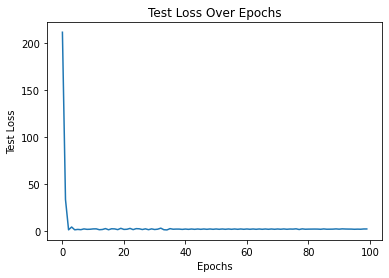

In [13]:
# Run the main function
if __name__ == "__main__":

    #print('OPTIONS ', options)
    # Tuning Parameters:
    import easydict
    from argparse import ArgumentParser
    parser = ArgumentParser()
    args = parser.parse_known_args()[0]
    #使用 easydict，可以创建一个命名空间对象，该对象具有字典的功能，并允许通过点号操作符来访问和设置键值对。
    args = easydict.EasyDict({
            "num_epochs": 100,
            "batch_size": 1,
            "lr": 0.0005,
            "tb_dir": "./runs",
            "final": False,
            "max_pool": False,
            "embedding_size" : 1024,
            "vocab_size" : 50000,
            "max_length" : 520,
            "num_heads" : 2,
            "depth" : 1,
            "seed" : 1,
            "lr_warmup" : 500,
            "gradient_clipping" : 1.0
    })
    evaluation = go(args)

    epoch_numbers = evaluation['epoch']
    test_accuracies = evaluation['Test Accuracy']

    # 将数据转换为 NumPy 数组
    epoch_numbers = np.array(epoch_numbers)
    test_accuracies = np.array(test_accuracies)

    # 获取排序后的索引
    sorted_indices = np.argsort(epoch_numbers)

    # 根据排序后的索引获取排序后的数据
    sorted_epoch_numbers = epoch_numbers[sorted_indices]
    sorted_test_accuracies = test_accuracies[sorted_indices]

    # 绘制迭代MSE折线图
    plt.plot(sorted_epoch_numbers, sorted_test_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')  # 或者 'Test Accuracy'，具体根据你的情况来确定
    plt.title('Test Loss Over Epochs')
    plt.show()